In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/LDS8_K270_ONLINE_DoThiPhuong/LDS8_K270_DoThiPhuong_Cuoi_ky/Cau_5/'

/content/gdrive/My Drive/LDS8_K270_ONLINE_DoThiPhuong/LDS8_K270_DoThiPhuong_Cuoi_ky/Cau_5


In [3]:
# LSTM for air pollution problem with regression framing
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
	#t
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	#t+1
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [5]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [6]:
# load the data
dataframe = pd.read_csv('AAPL.csv', index_col= 0)
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [7]:
dataset = dataframe[['Open']]
dataset = dataset.values.astype('float32')

In [8]:
import seaborn as sns

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [10]:
#split into train and test sets
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [11]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
type(trainX)

numpy.ndarray

In [13]:
print(trainX[:5])
print(trainY[:5])

[[0.00256878]
 [0.        ]
 [0.00029293]
 [0.00730075]
 [0.00709796]]
[0.         0.00029293 0.00730075 0.00709796 0.00799929]


In [14]:
print(testX[:5])
print(testY[:5])

[[0.22781047]
 [0.23055953]
 [0.22738233]
 [0.22959062]
 [0.23026657]]
[0.23055953 0.22738233 0.22959062 0.23026657 0.247527  ]


In [15]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0],1, testX.shape[1]))

In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape = (1, look_back)))
model.add(Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta = 0.0001,
    patience = 20,
    restore_best_weights = True
)

In [21]:
model.compile(loss = 'mean_squared_error', optimizer= 'adam')
history = model.fit(trainX, trainY,
                    validation_data = (testX, testY),
                    epochs = 100,
                    batch_size = 128,
                    callbacks = [early_stopping]
                    )

Epoch 1/100
6/6 [==============================] - 2s 92ms/step - loss: 0.0012 - val_loss: 0.0375
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0308
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 9.3293e-04 - val_loss: 0.0263
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 8.4144e-04 - val_loss: 0.0229
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 7.5216e-04 - val_loss: 0.0207
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 6.7611e-04 - val_loss: 0.0170
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 5.9690e-04 - val_loss: 0.0135
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 5.2629e-04 - val_loss: 0.0118
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 4.5923e-04 - val_loss: 0.0096

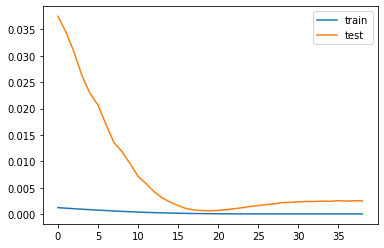

In [22]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [24]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [25]:
trainY[0][:5]

array([26.64249951, 26.67499903, 27.45249934, 27.43000031, 27.53000022])

In [26]:
trainPredict[:5]

array([[29.165895],
       [28.933435],
       [28.959925],
       [29.595066],
       [29.576649]], dtype=float32)

In [27]:
# calculate root mse
train_rmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f RMSE'% (train_rmse))
test_rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f RMSE'% (test_rmse))

Train RMSE: 1.03 RMSE
Test RMSE: 2.87 RMSE


In [28]:
train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train MAE: %.2f MAE'% (train_mae))
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('Test MAE: %.2f MAE'% (test_mae))

Train MAE: 0.81 MAE
Test MAE: 2.27 MAE


In [29]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

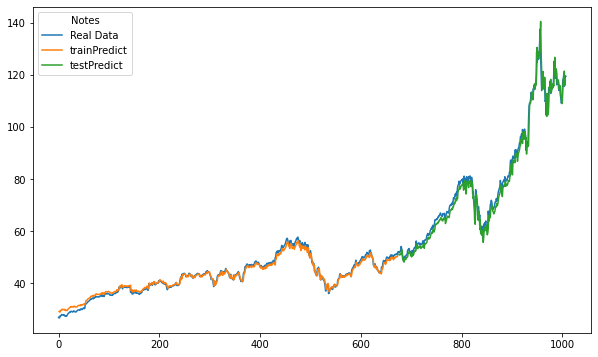

In [30]:
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title="Notes")
plt.show()

In [32]:
dataframe.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-12,119.620003,120.529999,118.570000,119.209999,119.209999,103162300
2020-11-13,119.440002,119.669998,117.870003,119.260002,119.260002,81581900


In [33]:
# x_new = 8 => next time = ?
x_new = scaler.transform([[119.620003	]])
x_new = numpy.reshape(x_new, (1, 1, 1))

y_new = model.predict(x_new)
y_new = scaler.inverse_transform(y_new)
y_new

array([[120.46662]], dtype=float32)